In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import scipy as sp
import fbprophet

sales_df = pd.read_csv("sales_train_validation.csv")
sales_train = sales_df.iloc[:,:sales_df.shape[1]-28]
sales_test = pd.concat([sales_df.iloc[:,:6], sales_df.iloc[:,sales_df.shape[1]-28:]], axis = 1)
sales_train

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,3,1,3,1,2,2,0,1,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,4,2,1,4,1,3,5,0,6,6
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,3,2,2,2,3,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,0,0,2,0,0,0,2,0,1
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,1,0,2,1,1,2,4


In [236]:
#Aggregate data by department

depts = list(set(sales_train.iloc[:,2]))
depts.sort()

dates = np.array('2011-01-29', dtype=np.datetime64) + np.arange(sales_train.shape[1]-6)

depts_by_day = pd.DataFrame(index = depts, columns = dates)

for dept in depts:
    depts_by_day.loc[dept, :] = np.array(np.sum(sales_train[sales_train['dept_id'] == dept].iloc[:,6:], axis = 0))
    
depts_by_day

,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-05,2011-02-06,2011-02-07,...,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27
FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,1586,...,2918,3273,3057,2749,3177,3095,3043,4563,5285,3956
FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,3684,...,5084,5702,6150,5012,4513,4447,4292,5379,5878,4966
FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,13631,...,18453,21024,22551,17149,16552,15720,15539,20964,25972,23314
HOBBIES_1,3610,3172,2497,2531,1714,3133,2855,3831,2741,2514,...,3441,4327,3596,2988,2789,3033,3010,3806,4037,3350
HOBBIES_2,154,185,185,138,100,87,89,155,158,101,...,353,408,410,354,351,389,342,424,439,293
HOUSEHOLD_1,4105,3858,2827,2732,1802,2664,3161,4334,3494,2857,...,7532,9209,9690,7217,6341,6386,6181,8255,9664,8253
HOUSEHOLD_2,1584,1776,1100,1133,927,1234,1415,1861,1481,1199,...,1871,2238,2371,1891,1752,1716,1596,2220,2588,2228


In [237]:
#Create projections by department for test set

projected_depts_by_day = pd.DataFrame(index = depts, columns = (dates[-1] + 1) + np.arange(28))

for dept in depts:
    ts = pd.DataFrame({"ds": dates, "y": depts_by_day.loc[dept]})
    prophet = fbprophet.Prophet()
    prophet.fit(ts)
    forecast = prophet.predict(prophet.make_future_dataframe(periods = 28, freq='D'))
    projected_depts_by_day.loc[dept, :] = np.array(forecast.iloc[len(ts):, 18])
    
projected_depts_by_day

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
FOODS_1,3096.83,3114.76,3171.73,3232.03,3548.82,3960.22,3611.46,3094.27,3090.63,3126.75,...,3320.15,3716.71,3357.76,2835.06,2830.51,2870.19,2918.55,3228.78,3638.9,3293.96
FOODS_2,5562.68,5148.04,5005.62,4906.3,5118.09,5901.31,6230.33,5491.36,5074.96,4931.9,...,5030.12,5828.58,6174.62,5454.07,5057.09,4934,4855.34,5088.74,5894.05,6245.17
FOODS_3,17550.2,16208.7,15986.8,16127,17992.9,21594.4,21836.9,17505.8,16151.5,15918.5,...,17812.7,21411.3,21653,17322.6,15970.6,15740.7,15875.1,17737.1,21336.4,21577.8
HOBBIES_1,3588.93,3468.7,3503.67,3518,3961.03,4545.89,4185.79,3667.86,3541.34,3569.13,...,3996.66,4565.12,4189.1,3655.97,3515.2,3529.9,3524.5,3948.67,4515.77,4139.27
HOBBIES_2,366.756,366.208,375.223,369.623,376.706,408.587,404.645,356.958,355.727,364.285,...,361.606,395.569,394.071,349.145,350.937,362.725,360.282,370.851,406.481,406.481
HOUSEHOLD_1,8013.81,7485.02,7417.77,7464.56,8383.1,9916.3,9642.24,8063.1,7526.61,7450.81,...,8341.7,9856.13,9563.71,7966.83,7413.39,7321.62,7344.34,8239.58,9750.52,9455.5
HOUSEHOLD_2,1871.78,1777.2,1780.32,1807.87,2021.03,2398.53,2346.97,1878.37,1784.38,1788.12,...,2043.34,2421.7,2370.82,1902.65,1808.82,1812.39,1840.06,2052.97,2429.81,2377.16


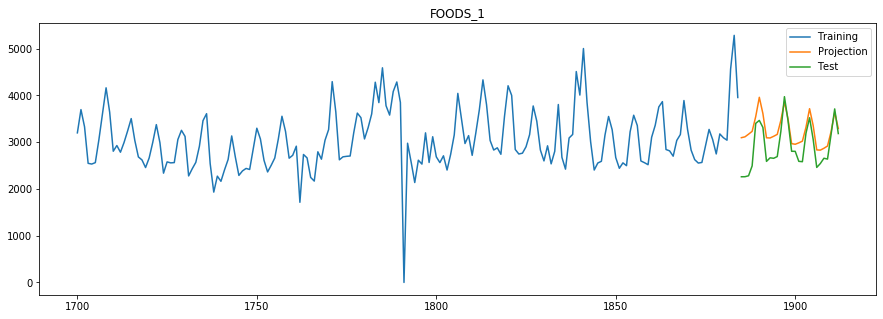

RMSE: 421.4676045531587


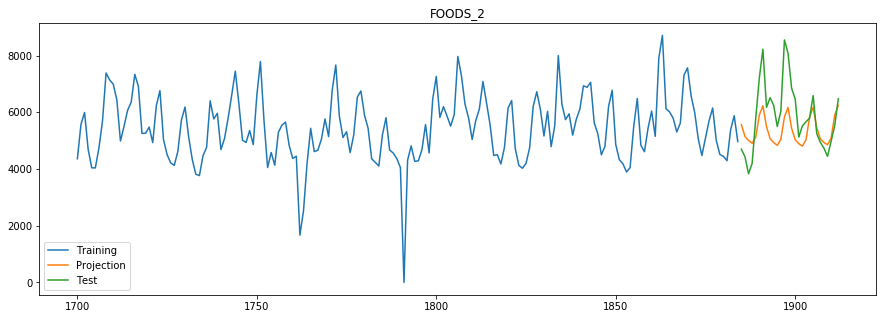

RMSE: 1062.7659905595012


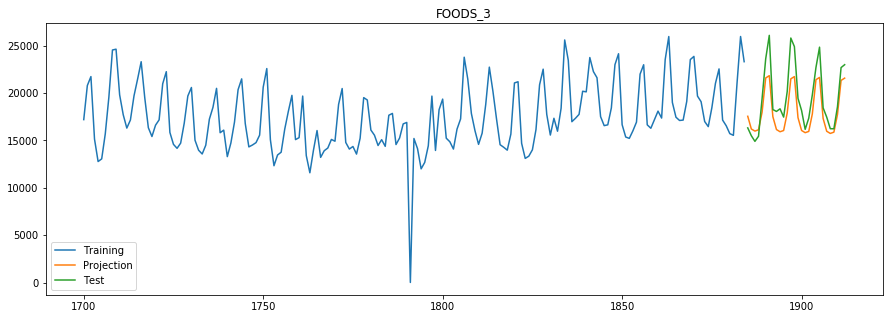

RMSE: 1970.077559550802


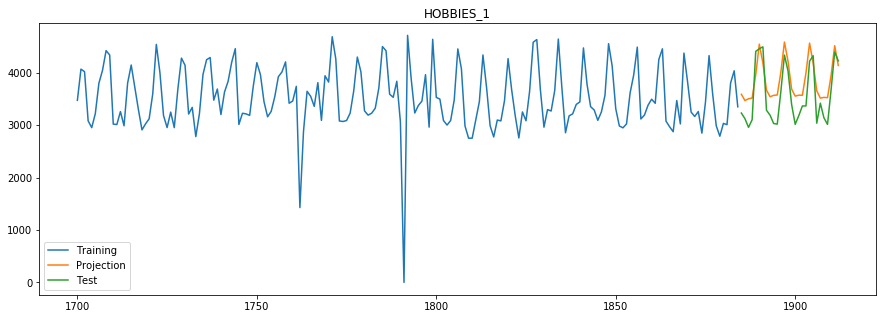

RMSE: 383.62810459988145


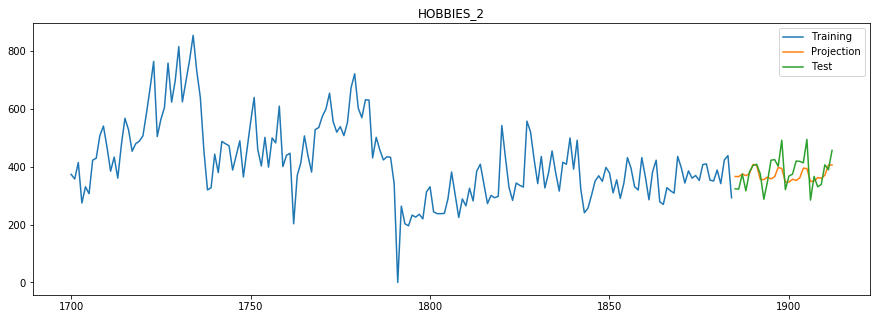

RMSE: 45.798122001077424


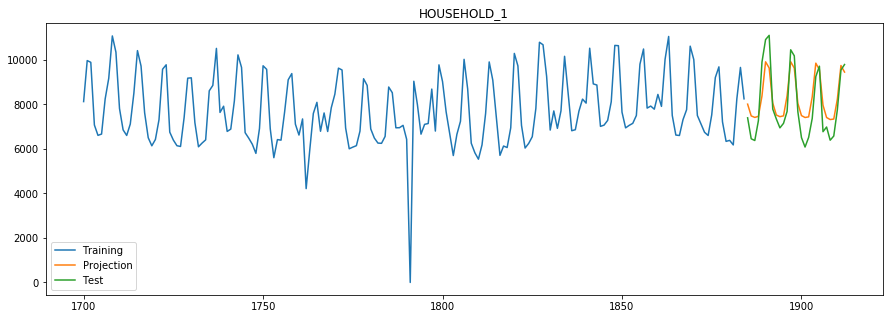

RMSE: 803.1317031683136


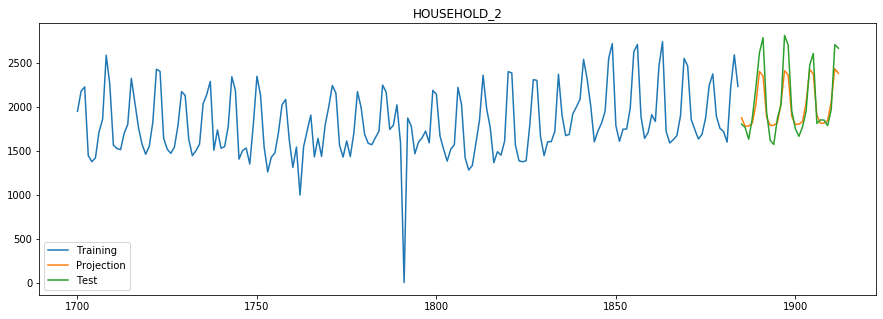

RMSE: 182.83072736239802


In [240]:
#Compare projections to actual

prophet_errors = []

for dept in depts:   
    ts = depts_by_day.loc[dept]
    pred_28 = projected_depts_by_day.loc[dept, :]
    actual_28 = np.array(np.sum(sales_test[sales_test['dept_id'] == dept].iloc[:,6:], axis = 0))
    
    plt.figure(figsize=(15, 5))
    plt.title(dept)
    plt.plot(np.arange(1700,len(ts)), ts.iloc[1700:])
    plt.plot(len(ts) + np.arange(28), pred_28)
    plt.plot(len(ts) + np.arange(28), actual_28)
    plt.legend(["Training", "Projection", "Test"])
    plt.show()
    print("RMSE:", rmse(pred_28, actual_28))
    prophet_errors.append(rmse(pred_28, actual_28))

In [241]:
#Split department projections into item projections

projected_item_by_day = pd.DataFrame(index = sales_train["id"], columns = (dates[-1] + 1) + np.arange(28))

for i in np.arange(sales_train.shape[0]):
    dept = sales_train.iloc[i, 2]
    sales_item_last_year = np.sum(sales_train.iloc[i, -365:])
    sales_dept_last_year = np.sum(depts_by_day.loc[dept][-365:])
    projected_item_by_day.iloc[i,:] = np.array(projected_depts_by_day.loc[dept, :]) * (sales_item_last_year/sales_dept_last_year)
    
projected_item_by_day

,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,0.682796,0.65992,0.666575,0.669299,0.753586,0.864856,0.796348,0.697811,0.67374,0.679028,...,0.760365,0.868515,0.796978,0.69555,0.668769,0.671565,0.670538,0.751234,0.859127,0.787497
HOBBIES_1_002_CA_1_validation,0.36397,0.351776,0.355323,0.356775,0.401705,0.461018,0.4245,0.371974,0.359142,0.361961,...,0.405319,0.462969,0.424835,0.370768,0.356492,0.357983,0.357435,0.400451,0.457964,0.419781
HOBBIES_1_003_CA_1_validation,0.516329,0.499031,0.504063,0.506123,0.56986,0.654003,0.602197,0.527684,0.509481,0.51348,...,0.574987,0.65677,0.602673,0.525974,0.505722,0.507836,0.50706,0.568082,0.64967,0.595504
HOBBIES_1_004_CA_1_validation,2.07378,2.0043,2.02451,2.03279,2.28878,2.62673,2.41866,2.11939,2.04628,2.06234,...,2.30937,2.63785,2.42057,2.11252,2.03118,2.03967,2.03655,2.28164,2.60933,2.39178
HOBBIES_1_005_CA_1_validation,1.14552,1.10714,1.1183,1.12287,1.26428,1.45096,1.33602,1.17071,1.13032,1.1392,...,1.27565,1.4571,1.33708,1.16691,1.12198,1.12667,1.12495,1.26034,1.44134,1.32117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_validation,0.601997,0.555983,0.54837,0.553178,0.617181,0.740719,0.749039,0.600473,0.554021,0.546027,...,0.611002,0.734439,0.742728,0.594192,0.547815,0.539928,0.544538,0.608409,0.73187,0.740151
FOODS_3_824_WI_3_validation,0.0329861,0.0304648,0.0300477,0.0303111,0.0338181,0.0405874,0.0410432,0.0329026,0.0303573,0.0299193,...,0.0334795,0.0402432,0.0406974,0.0325585,0.0300173,0.0295851,0.0298377,0.0333375,0.0401024,0.0405562
FOODS_3_825_WI_3_validation,0.659722,0.609296,0.600954,0.606223,0.676363,0.811747,0.820864,0.658053,0.607147,0.598385,...,0.669591,0.804864,0.813949,0.651169,0.600346,0.591702,0.596754,0.66675,0.802049,0.811125


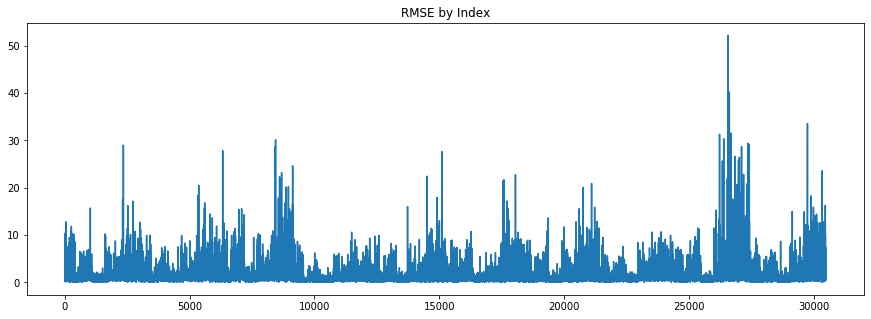

Average RMSE 1.393714612679012


In [242]:
#Compare item projections to actual

rmses = []

for index in np.arange(projected_item_by_day.shape[0]):
    pred_28 = np.array(projected_item_by_day.iloc[index,:])
    actual_28 = np.array(sales_test.iloc[index,6:])
    rmses.append(rmse(pred_28,actual_28))

plt.figure(figsize=(15, 5))
plt.title("RMSE by Index")
plt.plot(np.arange(projected_item_by_day.shape[0]), rmses)
plt.show()

print("Average RMSE", np.mean(rmses))

In [243]:
#Repeat process to create projections for next 28 days

dates = np.array('2011-01-29', dtype=np.datetime64) + np.arange(sales_df.shape[1]-6)

depts_by_day = pd.DataFrame(index = depts, columns = dates)

for dept in depts:
    depts_by_day.loc[dept, :] = np.array(np.sum(sales_df[sales_df['dept_id'] == dept].iloc[:,6:], axis = 0))
    
projected_depts_by_day = pd.DataFrame(index = depts, columns = ["F" + str(i) for i in np.arange(1,29)])

for dept in depts:
    ts = pd.DataFrame({"ds": dates, "y": depts_by_day.loc[dept]})
    prophet = fbprophet.Prophet()
    prophet.fit(ts)
    forecast = prophet.predict(prophet.make_future_dataframe(periods = 28, freq='D'))
    projected_depts_by_day.loc[dept, :] = np.array(forecast.iloc[len(ts):, 18])
    
projected_item_by_day = pd.DataFrame(index = sales_df["id"], columns = ["F" + str(i) for i in np.arange(1,29)])

for i in np.arange(sales_df.shape[0]):
    dept = sales_df.iloc[i, 2]
    sales_item_last_year = np.sum(sales_df.iloc[i, -365:])
    sales_dept_last_year = np.sum(depts_by_day.loc[dept][-365:])
    projected_item_by_day.iloc[i,:] = np.array(projected_depts_by_day.loc[dept, :]) * (sales_item_last_year/sales_dept_last_year)

projected_item_by_day_out = pd.concat([projected_item_by_day, projected_item_by_day])
projected_item_by_day_out.index = np.append(sales_df["id"], [_id[:-10]+"evaluation" for _id in sales_df["id"]])

projected_item_by_day_out

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
HOBBIES_1_001_CA_1_validation,0.680391,0.654046,0.657365,0.657379,0.74128,0.852346,0.781194,0.677435,0.651639,0.655505,...,0.743538,0.855757,0.78579,0.683256,0.658733,0.663923,0.66586,0.751733,0.864822,0.795739
HOBBIES_1_002_CA_1_validation,0.353913,0.34021,0.341936,0.341943,0.385585,0.443357,0.406347,0.352375,0.338957,0.340968,...,0.38676,0.445131,0.408738,0.355403,0.342647,0.345347,0.346354,0.391023,0.449847,0.413913
HOBBIES_1_003_CA_1_validation,0.534985,0.51427,0.51688,0.516891,0.582861,0.670191,0.614245,0.53266,0.512378,0.515417,...,0.584637,0.672873,0.617859,0.537238,0.517955,0.522036,0.523559,0.591081,0.680001,0.625682
HOBBIES_1_004_CA_1_validation,1.9671,1.89093,1.90053,1.90057,2.14314,2.46424,2.25853,1.95855,1.88397,1.89515,...,2.14966,2.4741,2.27182,1.97538,1.90448,1.91949,1.92509,2.17336,2.50031,2.30059
HOBBIES_1_005_CA_1_validation,1.13033,1.08656,1.09207,1.0921,1.23148,1.41599,1.29779,1.12542,1.08256,1.08898,...,1.23523,1.42166,1.30543,1.13509,1.09435,1.10297,1.10619,1.24885,1.43672,1.32195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_evaluation,0.581902,0.537184,0.528704,0.532541,0.593525,0.711334,0.719148,0.575621,0.531143,0.522965,...,0.58836,0.707547,0.716841,0.574887,0.532065,0.525617,0.53161,0.594862,0.715037,0.725298
FOODS_3_824_WI_3_evaluation,0.0247034,0.022805,0.022445,0.0226079,0.0251968,0.0301981,0.0305299,0.0244367,0.0225485,0.0222014,...,0.0249776,0.0300374,0.0304319,0.0244056,0.0225877,0.0223139,0.0225684,0.0252536,0.0303553,0.0307909
FOODS_3_825_WI_3_evaluation,0.636798,0.587862,0.578582,0.582781,0.649518,0.778441,0.786992,0.629925,0.581251,0.572302,...,0.643866,0.774297,0.784467,0.629121,0.58226,0.575204,0.581762,0.650981,0.782493,0.793722
FOODS_3_826_WI_3_evaluation,1.0842,1.00089,0.985086,0.992235,1.10586,1.32536,1.33992,1.0725,0.989629,0.974393,...,1.09624,1.31831,1.33562,1.07113,0.991348,0.979334,0.9905,1.10835,1.33226,1.35138
